In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math

eng = matlab.engine.start_matlab()

In [2]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[1580-1][0])
month = np.int16(quietDays[1580-1][1])
day = np.int16(quietDays[1580-1][2])
hour = 0
minute = 0
second = 0
numberOfDaysWithData = 2


startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, hour, minute, second)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [3]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 218 ms, sys: 104 ms, total: 322 ms
Wall time: 6.99 s


In [4]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
    x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x,10)

In [5]:
%%time
stationIndicatorVariation.clear()
numberOfMinutesNeededInTheTimeStamp = 2880
timeBetweenValues = 8
dataResolution = 0
dataBeforeNormalizaton = np.array([])

if 360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)==0:
    dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)
    
    for st in allStationCodes:
        delta = endDate-startDate
        totalMinutes = (delta.total_seconds()+1)/60
        for i in range(0, np.int16(totalMinutes), timeBetweenValues):
            try:
                update = datetime.timedelta(minutes=i)
                currentDate = startDate+update
                stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
            except:
                None
            
else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit



CPU times: user 21.6 s, sys: 612 ms, total: 22.2 s
Wall time: 36.7 s


In [6]:
normalized01StationIndicatorVariation = defaultdict(list)

def ManuallyNormalizeData01():

    max_values = np.array([])
    min_values = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                localMin=min(stationIndicatorVariation[st])
                localMax=max(stationIndicatorVariation[st])
        
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - localMin) / (localMax - localMin))



# NormalizeDataGauss()
# NormalizeData01()
ManuallyNormalizeData01()

In [7]:
def indexValueOnLocalTime(array, st, i):
    numberOfValuesLong = numberOfMinutesNeededInTheTimeStamp/timeBetweenValues
    localTimeValuesArray = np.full((180, numberOfValuesLong), np.nan)
    long = float(stationsOut[st].get("longeo"))
    shiftValues = np.round((long*4)/timeBetweenValues,0)
    initialShiftValues = shiftValues
    z=0
    for y in range(numberOfValuesLong,array.shape[1]):
        if y+shiftValues>=array.shape[1]:
            localTimeValuesArray[i][np.int16(np.int16(y-(y-shiftValues+1)))] = array[i][numberOfValuesLong-z-1]
            shiftValues-=1
            z+=1
        else:
            localTimeValuesArray[i][np.int16(y+shiftValues)-numberOfValuesLong] = array[i][y]
            
    return localTimeValuesArray[i] 

In [8]:
indicatorVariationArray = np.full((180, (1440*numberOfDaysWithData)/timeBetweenValues), np.nan)
indicatorVariationArrayLocalTime = np.full((180, numberOfMinutesNeededInTheTimeStamp/timeBetweenValues), np.nan)


def makeIndicatorVariationArray(normalizedGauss, normalizedScaler):
#     for st in allStationCodes:
        st='clf'
        for i in range(-90, 90):
            if not isinstance(stationsOut[st], matlab.mlarray.double):
                if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                    if st=="clf": print i+90
#                     if i+90==138: print st
#                     print(st)
                    if normalizedScaler: 
                        indicatorVariationArray[i+90]=np.array(normalized01StationIndicatorVariation[st])
                        indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(indicatorVariationArray, st, i+90)
                        
                    elif normalizedGauss: 
                        indicatorVariationArray[i+90]=AdaptDimensions(np.array(normalizedStationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                    else: 
                        indicatorVariationArray[i+90]=AdaptDimensions(np.array(stationIndicatorVariation[st]), indicatorVariationArray.shape[1])
                else:
                    None
                    
makeIndicatorVariationArray(False,True)

138


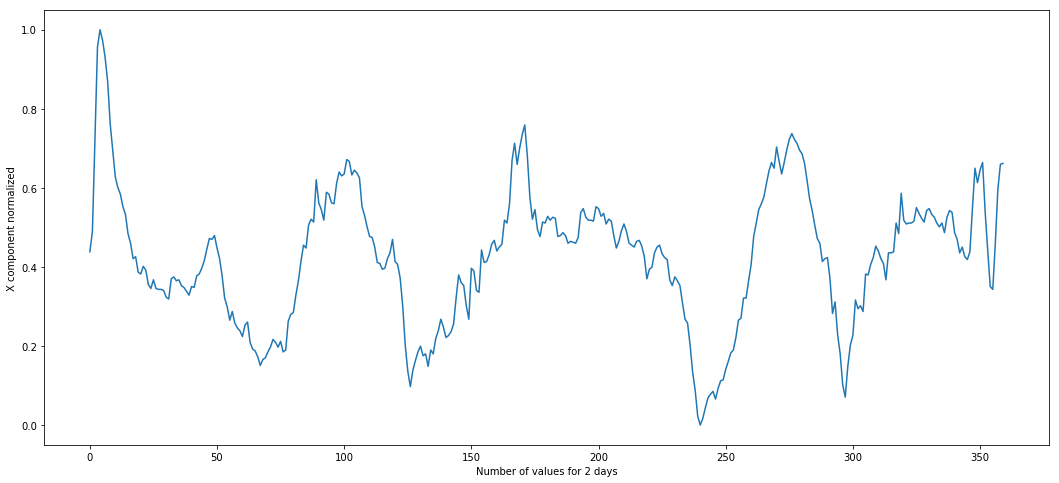

In [66]:
y = np.array(indicatorVariationArray[138].reshape(indicatorVariationArray[138].shape[0],1))
fig, ax1=plt.subplots(1,1)
ax1.plot(y)
ax1.set_xlabel("Number of values for 2 days")
ax1.set_ylabel("X component normalized")
fig.set_size_inches(18,8)
fig.savefig("LSTM_fullSet.png")
fig.show()

In [68]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [70]:
x = np.arange(0, indicatorVariationArray.shape[1], 1)
y = indicatorVariationArray[138]
dataSet=np.empty([360,360])

for i in range(0,360,1):
    a = np.array([[x[i]],[np.round(y[i], 5)]])
#     print a
    dataSet[i][0] = x[i]
    dataSet[i][1] = y[i]

In [71]:
dataset = pd.DataFrame({'time': x, 'indicator': y})
indicator_data = dataset['indicator'].values

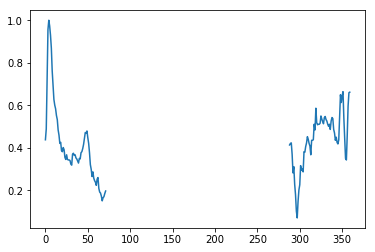

In [72]:
datasetWithGap = np.array([])
splitGap = int(0.20*len(indicator_data))
datasetWithGap = np.copy(indicator_data)
datasetWithGap[splitGap:len(indicator_data)-splitGap] = np.nan
datasetWithGapTest = indicator_data[splitGap:len(indicator_data)-splitGap]
plt.plot(datasetWithGap)
# plt.plot(datasetWithGapTest)

In [73]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.DataFrame({'time': x, 'indicator': y})


indicator_data = dataset['indicator'].values
indicator_data = indicator_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(indicator_data))

indicator_train = indicator_data[:split]
indicator_test = indicator_data[split:]

look_back = 1

train_generator = TimeseriesGenerator(indicator_train, indicator_train, length=look_back, batch_size=1)     
test_generator = TimeseriesGenerator(indicator_test, indicator_test, length=look_back, batch_size=1)

In [74]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10
287/287 [==============================] - 1s 4ms/step - loss: 0.1200
Epoch 2/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 3/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 4/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 5/10
287/287 [==============================] - 0s 997us/step - loss: 0.0086
Epoch 6/10
287/287 [==============================] - 0s 987us/step - loss: 0.0063
Epoch 7/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 8/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 9/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.0022


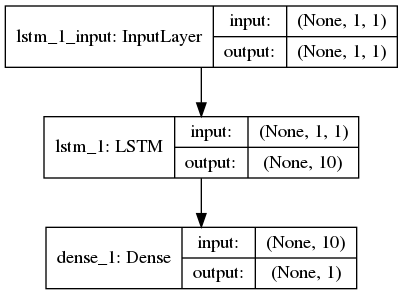

In [94]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [76]:
from sklearn.metrics import mean_squared_error

y_true = dataset['indicator'][split+look_back:]
y_pred = model.predict(test_generator)
mean_squared_error(y_true, y_pred)
# model.evaluate_generator(test_generator, 3000)

0.003247294487282314

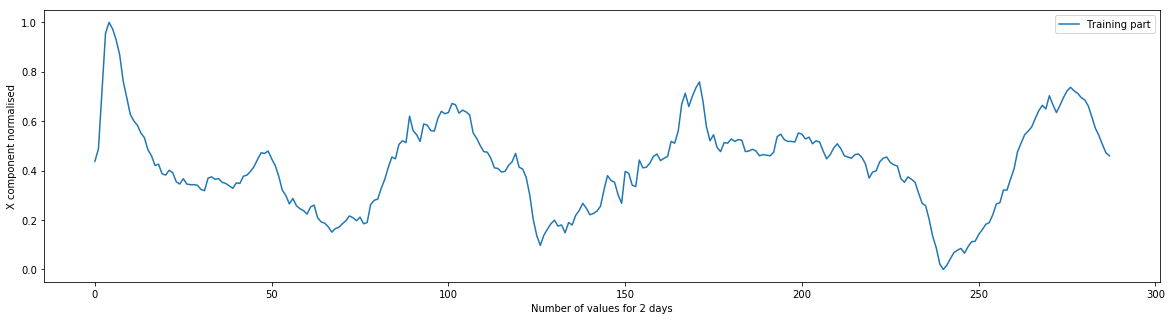

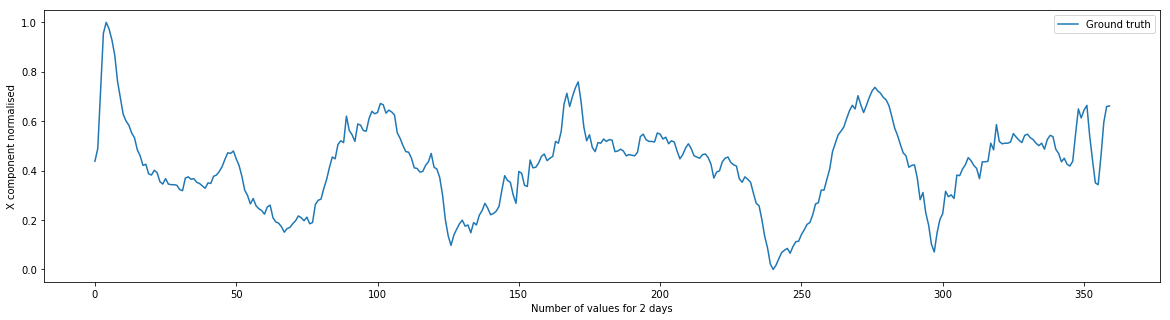

In [95]:
xPlot = np.arange(split+look_back-1,360-1,1)
fig,(ax2) = plt.subplots(1,1)
fig2,(ax3)=plt.subplots(1,1)
# ax1.plot(dataset['indicator'])
ax2.plot(indicator_train, label='Training part')
# ax2.plot(xPlot,y_pred, label='Prediction')
ax3.plot(dataset['indicator'], label='Ground truth')
# ax3.plot(xPlot,y_pred, label='Prediction')
fig.set_size_inches(20,5)
ax2.legend(loc="best")
ax2.set_xlabel('Number of values for 2 days')
ax2.set_ylabel('X component normalised')
# fig.savefig("Train")
fig.show()
fig2.set_size_inches(20,5)
ax3.set_xlabel('Number of values for 2 days')
ax3.set_ylabel('X component normalised')
ax3.legend(loc="best")
fig2.savefig("AllData_LSTM")
fig2.show()

In [ ]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

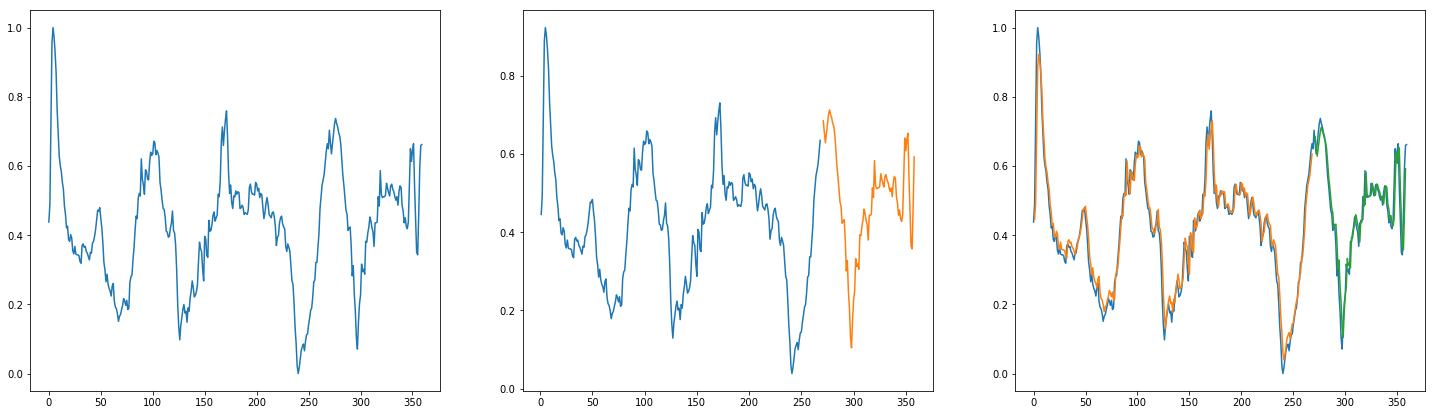

In [300]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
 
ax1.plot(dataset)
ax2.plot(trainPredictPlot)
ax2.plot(testPredictPlot)
ax3.plot(dataset)
ax3.plot(trainPredictPlot)
ax3.plot(testPredictPlot)
fig.set_size_inches(25,7)
fig.show()

In [48]:
X=np.array([])
Y=np.array([])
Z=np.array([])

for t in range(0, indicatorVariationArrayLocalTime.shape[1]):
    Y = np.append(Y, t)
    for l in range(0, indicatorVariationArrayLocalTime.shape[0]):
        X = np.append(X, l)
        if not math.isnan(indicatorVariationArrayLocalTime[l][t]):
            Z = np.append(Z, indicatorVariationArrayLocalTime[l][t])

X=X.reshape(X.shape[0], 1)
Y=Y.reshape(Y.shape[0], 1)
Z=Z.reshape(Z.shape[0], 1)

In [49]:
value = 50
print(X.shape,Y.shape,Z.shape)

((32400, 1), (180, 1), (12420, 1))


ValueError: shape mismatch: objects cannot be broadcast to a single shape

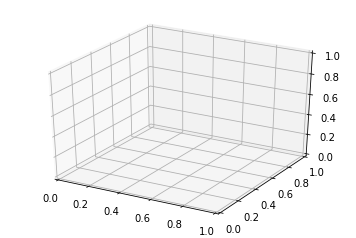

In [50]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.plot_surface(X,Y,Z,cmap='afmhot', linewidth=0)
plt.show()
